# Mid Semester Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Yuval Saadaty 205956634
<br>
Student 2: Reut Dayan 206433245
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from collections import defaultdict


[autoreload of gym.core failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: render() requires a code object with 1 free vars, not 0
]
[

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)
        self.open_door_once = False
        self.door_row = 0
        self.key_row = 0
        self.key_col = 0

    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def set_position(self, door_row,key_row,key_col):
      self.door_row = door_row
      self.key_row = key_row
      self.key_col = key_col

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())

        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        # self.key_pos = (self.key_col, self.key_row)
        # self.door_pos = (self.partition_col, self.door_row)
        self.open_door_once = False
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)
        self.open_door_once = False

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Wrappers

In [ ]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
import numpy as np

max_env_steps = 100


class SimFlatObsWrapper(gym.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()

    def get_state(self):
       return  (
            self.get_direction(),
            self.get_position(),
            self.get_goal_pos())

    def step(self, action):
        env = self.unwrapped
        env.step_count += 1
        terminated = False
        truncated = False

        # Get the position in front of the agent
        fwd_pos = env.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = env.grid.get(*fwd_pos)

        # Rotate left
        if action == env.actions.left:
            reward =-5

            env.agent_dir -= 1
            if env.agent_dir < 0:
                env.agent_dir += 4

        # Rotate right
        elif action == env.actions.right:
            reward =-1
            env.agent_dir = (env.agent_dir + 1) % 4

        # Move forward
        elif action == self.actions.forward:
            if self.is_wall_front_pos():
              reward = -100
            else :
               reward = 2
            if fwd_cell is None or fwd_cell.can_overlap():
                env.agent_pos = tuple(fwd_pos)
            if fwd_cell is not None and fwd_cell.type == "goal":
                terminated = True
                reward = 100
            if fwd_cell is not None and fwd_cell.type == "lava":
                terminated = True

        # Done action (not used by default)
        elif action == env.actions.done:
            reward = 100
            pass

        else:
            reward = -1
            raise ValueError(f"Unknown action: {action}")

        if env.step_count >= env.max_steps:
            truncated = True

        if env.render_mode == "human":
            env.render()

        obs = env.gen_obs()

        return obs, reward, terminated, truncated, {}


class KeyFlatObsWrapper(gym.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps
        self.get_init_map()
        self.open_door_once = False


    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()

        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def is_open_door_once(self):
        return self.unwrapped.open_door_once

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


    def get_state(self):
       return  (
            self.get_direction(),
            self.get_position(),
            self.get_goal_pos(),
            self.get_door_pos(),
            self.get_key_pos(),
            self.is_carrying_key(),
            self.is_door_open(),
            self.is_open_door_once())

    def step(self, action):
        env = self.unwrapped
        env.step_count += 1
        terminated = False
        truncated = False

        # Get the position in front of the agent
        fwd_pos = env.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = env.grid.get(*fwd_pos)

        # Rotate left
        if action == env.actions.left:
            if self.is_door_open() or self.is_open_door_once():
                reward = -20
            else:
              reward =-7

            env.agent_dir -= 1
            if env.agent_dir < 0:
                env.agent_dir += 4

        # Rotate right
        elif action == env.actions.right:
            if self.get_position()[1] == self.get_door_pos()[1]  and (self.get_door_pos()[0]-self.get_position()[0] ==1) and env.agent_dir !=0 and not self.is_open_door_once():
              reward = 10
            else:
               reward =-1
            env.agent_dir = (env.agent_dir + 1) % 4

        # Move forward
        elif action == self.actions.forward:
            if self.is_wall_front_pos() and not self.is_door_front_pos() :
              reward = -100
            elif self.get_door_pos() == self.get_position() and self.is_door_open or (self.is_door_front_pos() and self.is_door_open()):
              reward = 10
            elif self.is_door_open():
               reward = 7
            else :
               reward = 5
            if fwd_cell is None or fwd_cell.can_overlap():
                env.agent_pos = tuple(fwd_pos)
            if fwd_cell is not None and fwd_cell.type == "goal":
                terminated = True
                reward = 100
            if fwd_cell is not None and fwd_cell.type == "lava":
                terminated = True

        # Pick up an object
        elif action == env.actions.pickup:
            is_carrying  = False
            if fwd_cell and fwd_cell.can_pickup():
                if env.carrying is None:
                    is_carrying = True
                    reward = 100
                    env.carrying = fwd_cell
                    env.carrying.cur_pos = np.array([-1, -1])
                    env.grid.set(fwd_pos[0], fwd_pos[1], None)
            if not is_carrying:
               reward = -100


        # Drop an object
        elif action == self.actions.drop:
            reward = -1
            if not fwd_cell and env.carrying:
                env.grid.set(fwd_pos[0], fwd_pos[1], self.carrying)
                env.carrying.cur_pos = fwd_pos
                env.carrying = None


        # Toggle/activate an object
        elif action == env.actions.toggle:
            if fwd_cell:
              if self.is_carrying_key() and not self.is_door_open() and  self.is_door_front_pos() and not self.is_open_door_once():
                  env.open_door_once = True
                  reward = 100
              else:
                  reward =-1
              fwd_cell.toggle(env, fwd_pos)
            else:
              reward = -1

        # Done action (not used by default)
        elif action == env.actions.done:
            reward = 100
            pass

        else:
            reward = -1
            raise ValueError(f"Unknown action: {action}")

        if env.step_count >= env.max_steps:
            truncated = True

        if env.render_mode == "human":
            env.render()

        obs = env.gen_obs()

        return obs, reward, terminated, truncated, {}



In [ ]:
import gym
import numpy as np
import random
import gym_minigrid
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
from numpy import load
from numpy import save
import gym
import numpy as np



```
# This is formatted as code
```

# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

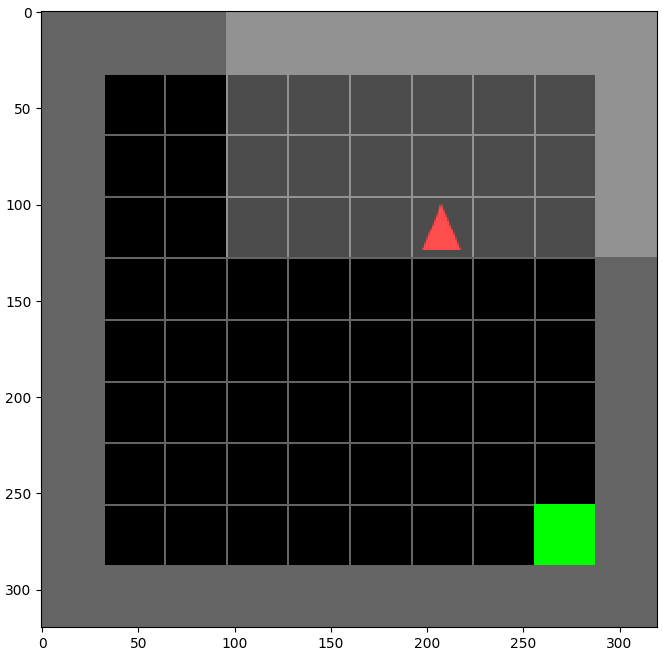

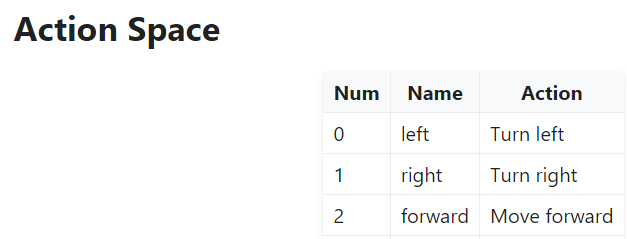

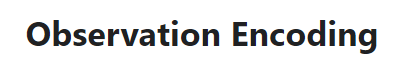

Agent Direction,
Agent Position,
Goal Position

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (5, 2)
Goal position:  (1, 8)
Number of actions: 3


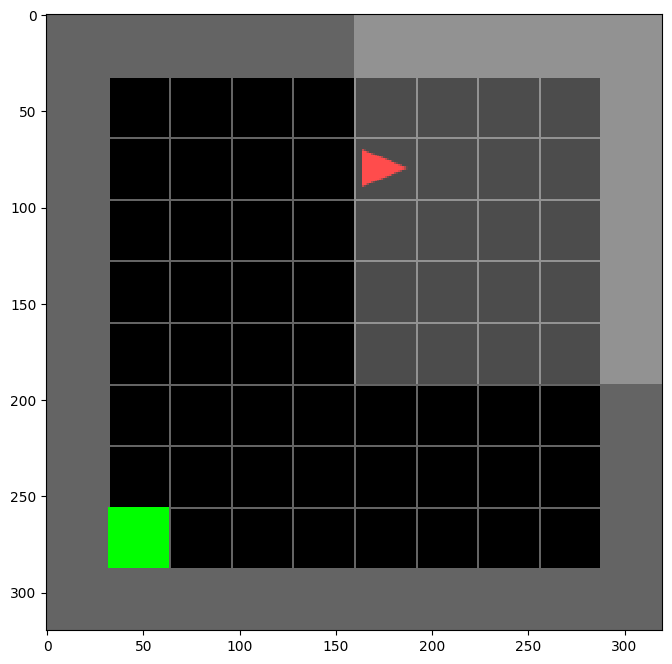

In [ ]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
screen = env.render()
plt.imshow(screen)

print('Map Height:', env.height-2)
print('Map Width:', env.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())

action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

# Checking the best hyperparameter

In [ ]:

def checkingTheBestHyperparameter(algorithm, is_with_key=True):
    learning_rate_values = [0.1, 0.2, 0.3, 0.4]  # Learning rate (alpha)
    discount_factor_values = [0.8, 0.85, 0.9, 0.95, 0.99]  # Discount factor (gamma)

    # Loop through the required number of episodes
    episode = 0
    min_lr = 0
    min_discount = 0
    min_steps = float("inf")
    best_steps_array = []
    for LEARNING_RATE in learning_rate_values:
        for DISCOUNT in discount_factor_values:
            steps_array = []
            episode = 0
            epsilon = 0.9
            EPISODES = 700
            START_EPSILON_DECAYING = 0.001
            END_EPSILON_DECAYING = EPISODES//10
            epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
            if is_with_key:
              q_table = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
              q_table1 = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
              q_table2 = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
            else:
              q_table = defaultdict(lambda: [0,0,0])
              q_table1 = defaultdict(lambda: [0,0,0])
              q_table2 = defaultdict(lambda: [0,0,0])
            while episode<EPISODES:
                episode+=1
                # Evaluate current hyperparameters
                if is_with_key:
                  env.set_position(3, 5, 1)

                success, steps = algorithm(q_table, epsilon)
                # Update best hyperparameters if current configuration is better
                #print(f"Current episode: {episode}, steps: {steps}, epsilon: {epsilon} ")
                steps_array.append(steps)

                # Move epsilon towards its ending value, if it still needs to move
                if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
                    epsilon = max(0, epsilon - epsilon_change)
                if epsilon < 0.004:
                    break
            if min_steps > sum(steps_array):
                min_steps=sum(steps_array)
                min_lr = LEARNING_RATE
                min_discount = DISCOUNT
                best_steps_array = steps_array
            print(f'episode: {episode}, total steps : {sum(steps_array)}, LEARNING_RATE: {LEARNING_RATE},DISCOUNT: {DISCOUNT} ')

    print(f'min_lr: {min_lr}, min_discount : {min_discount}, min_steps: {min_steps}')

    # Plot the training progress
    plt.plot(range(1, len(best_steps_array) + 1), best_steps_array, marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Total steps')
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()
    print(success)

# Q-LEARNING – OFF-POLICY TD CONTROL
$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{old value}} \bigg) }^{\text{temporal difference}}$

There are several parameters in this equation:
* alpha ($\alpha$) - The learning rate, how much should the current step cause the Q-values to be updated.
* lambda ($\lambda$) - The discount factor is the percentage of future reward that the algorithm should consider in this update.

This equation modifies several values:

* $Q(s_t,a_t)$ - The Q-table.  For each combination of states, what reward would the agent likely receive for performing each action?
* $s_t$ - The current state.
* $r_t$ - The last reward received.
* $a_t$ - The action that the agent will perform.

* **LEARNING_RATE** The rate at which previous Q-values are updated based on new episodes run during training.
* **DISCOUNT** The amount of significance to give estimates of future rewards when added to the reward for the current action taken.  A value of 0.95 would indicate a discount of 5% to the future reward estimates.
* **EPISODES** The number of episodes to train over.
* **START_EPSILON_DECAYING** Epsilon is the probability that the agent will select a random action over what the Q-Table suggests. This value determines the starting probability of randomness.
* **END_EPSILON_DECAYING** How many episodes should elapse before epsilon goes to zero and no random actions are permitted. For example, EPISODES//10  means only the first 1/10th of the episodes might have random actions.

In [ ]:

import gym
import numpy as np

# Run one game.
# The q_table to use is provided.  We also
# provide a flag to indicate if the game should be
# rendered/animated.  Finally, we also provide
# a flag to indicate if the q_table should be updated.
LEARNING_RATE = 0.4
DISCOUNT = 0.8
def run_game(q_table,epsilon, video= None):
    done = False
    env.reset()
    state = env.get_state()
    success = False
    steps = 0

    while not done:
        steps += 1
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action
            action = np.argmax(q_table[state])
        else:
            # Explore - t
            action = np.random.randint(0, env.action_space.n)
        if action == 4 or action == 6 :
            continue
        # Run simulation step
        new_state, reward, done, _ ,_= env.step(action)
        if video and not video.closed:
          video.append_data(env.render())

        new_state = env.get_state()
        if done :
          success = True

        # Update q-table
        max_future_q = max(q_table[new_state])
        current_q = q_table[state][action]
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[state][action] = new_q
        state = new_state
    if video:
      video.close()
    return success, steps


episode: 70, total steps : 9015, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 9764, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 8076, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 9677, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 9949, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 8184, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 8876, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 8310, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 8047, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 9324, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 9373, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 10240, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 6046, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 8934, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70, total steps : 8537, LEARNING_RATE: 0.3,D

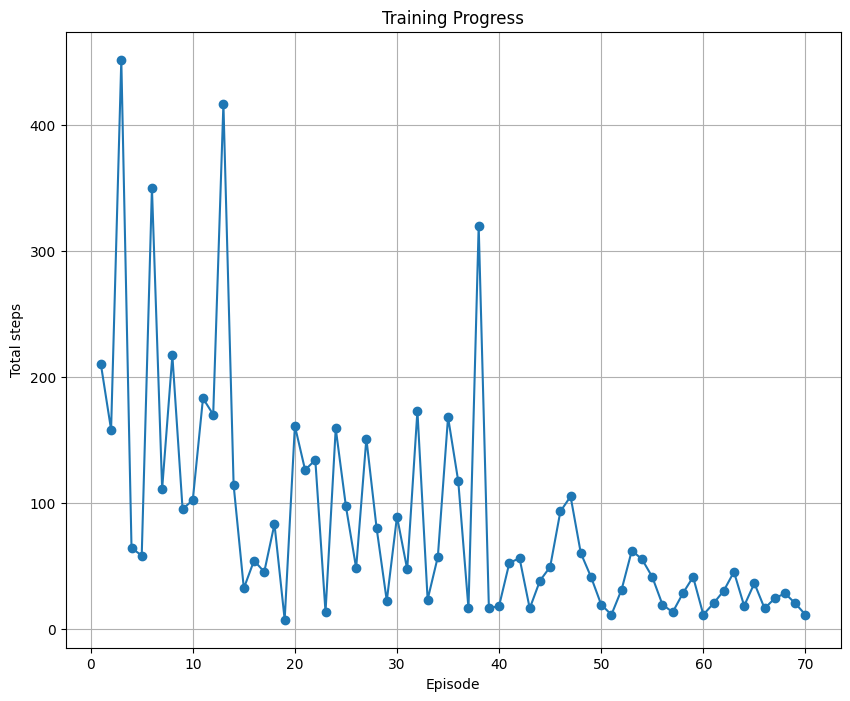

True


In [ ]:
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game, False)

##  n-step temporal difference learning
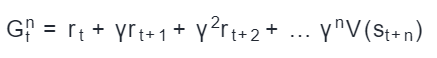

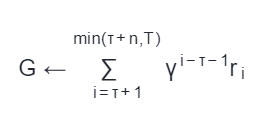

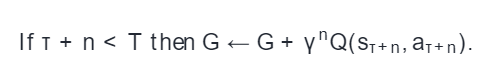

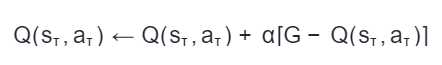

In [ ]:
def run_game_n_steps(q_table, epsilon):
    done = False
    env.reset()
    state = env.get_state()
    success = False
    steps = 0
    n_step_buffer = []  # Buffer to store N-step transitions
    while not done:
        steps += 1
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action
            action = np.argmax(q_table[state])
        else:
            # Explore
            action = np.random.randint(0, env.action_space.n)
        if action == 4 or action == 6:
            continue
        # Run simulation step
        new_state, reward, done, _ , _= env.step(action)
        new_state = env.get_state()

        # Store N-step transition
        n_step_buffer.append((state, action, reward))

        # Update Q-values using N-step return
        n_steps = 3
        if len(n_step_buffer) >= n_steps:
            state_update, action_update, reward_update = n_step_buffer.pop(0)
            n_step_return = sum([reward_update * (DISCOUNT**i) for i, (_, _, reward_update) in enumerate(n_step_buffer)]) + (DISCOUNT**n_steps) * q_table[new_state][np.argmax(q_table[new_state])]
            q_table[state_update][action_update] += LEARNING_RATE * (n_step_return - q_table[state_update][action_update])

        if done:
            success = True

        state = new_state

    return success, steps

episode: 70, total steps : 43506, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 105315, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 749749, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 112378, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 508866, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 24654, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 62281, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 123438, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 57176, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 81595, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 50548, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 55277, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 139761, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 98746, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70, total steps : 32376, 

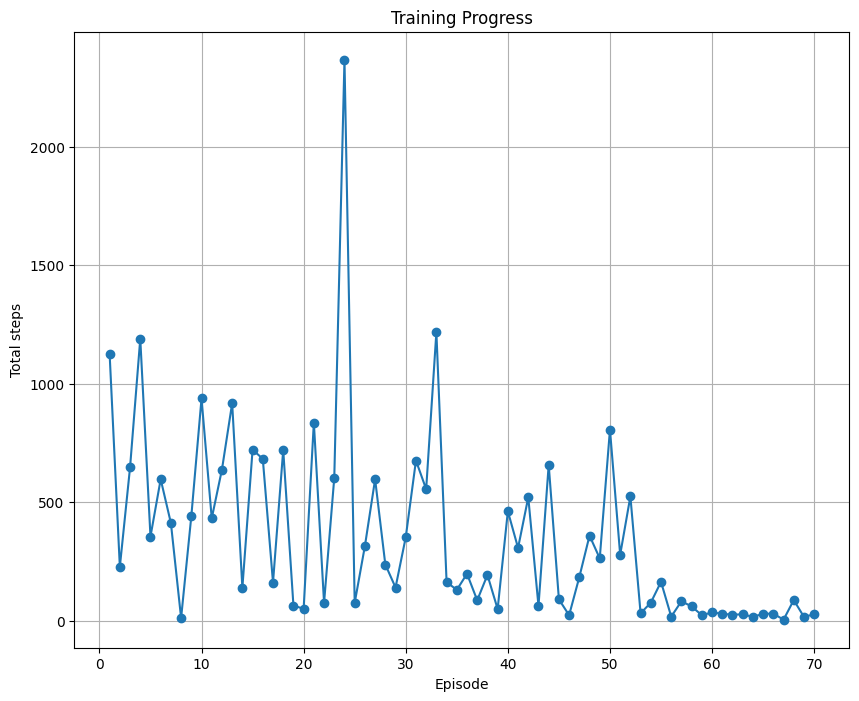

True


In [ ]:
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game_n_steps, False)

# Double Q - learning


In [ ]:
q_table1 = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
q_table2 = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
def run_game_double_q(q_table, epsilon):
    done = False
    env.reset()
    state = env.get_state()
    success = False
    steps = 0

    while not done:
        steps += 1

        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use combined Q-values to select current best action
            if(np.max(q_table1[state]) > np.max(q_table2[state])):
              action = np.argmax(q_table1)
            else:
              action = np.argmax(q_table2)
        else:
            # Explore - choose a random action
            action = np.random.randint(0, env.action_space.n)

        # Skip certain actions (if necessary)
        if action == 4 or action == 6:  # Adjust as needed based on your environment's action space
            continue

        # Execute the chosen action and observe the new state and reward
        new_state, reward, done, _, _ = env.step(action)
        new_state = env.get_state()

        # Determine which Q-table to update
        if np.random.random() < 0.5:
            # Update Q1 using Q2 for action selection
            max_future_q = np.max(q_table2[new_state])
            q_table1[state][action] = (1 - LEARNING_RATE) * q_table1[state][action] + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        else:
            # Update Q2 using Q1 for action selection
            max_future_q = np.max(q_table1[new_state])
            q_table2[state][action] = (1 - LEARNING_RATE) * q_table2[state][action] + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # Update the current state to the new state
        state = new_state

        # Check if the episode is completed
        if done:
            success = True

    return success, steps

episode: 70, total steps : 208171, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 437928, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 239997, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 242448, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 255515, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 269251, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 338910, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 298974, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 204409, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 417651, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 312705, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 252442, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 593007, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 272110, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70, total steps :

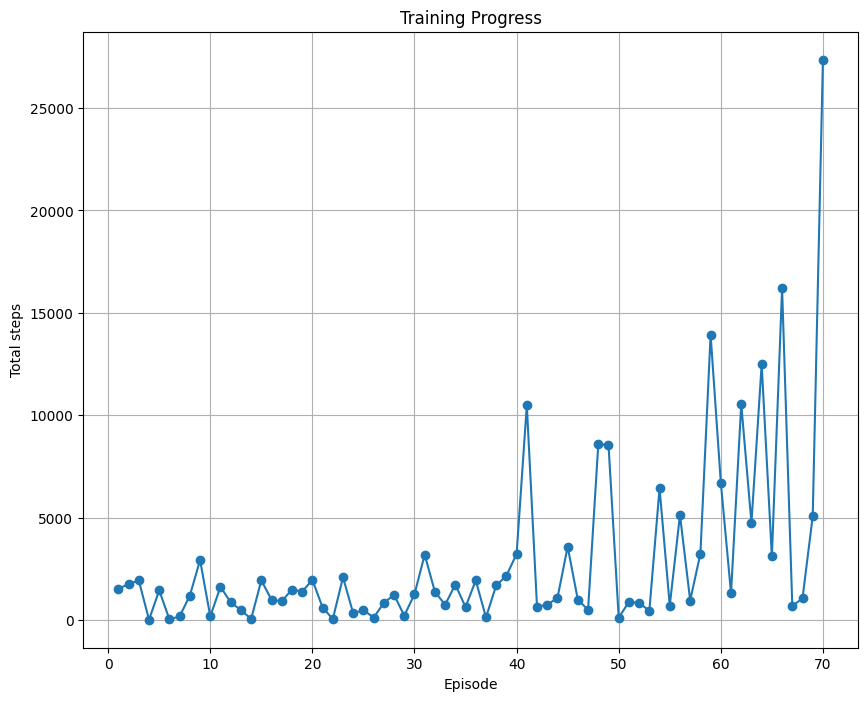

True


In [ ]:
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game_double_q, False)

# Runing the wining algorithm
filming a video in the middle of the trainig and in the end of the training

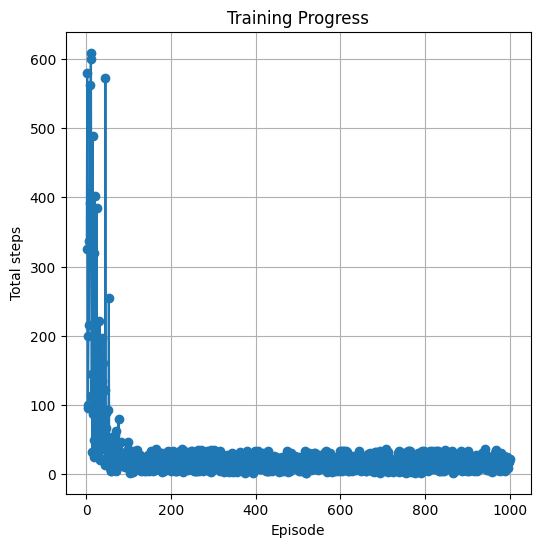

In [ ]:
end_video_filename = f'end empty env training.mp4'
middle_video_filename = f'middle empty env training.mp4'
q_table = defaultdict(lambda: [0,0,0])

def trainingEmptyEnv():
  env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
  episode = 0
  steps_array = []
  epsilon = 0.9
  EPISODES = 1000
  START_EPSILON_DECAYING = 0.001
  END_EPSILON_DECAYING = EPISODES//10
  epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
  LEARNING_RATE = 0.3
  DISCOUNT = 0.9
  # Loop through the required number of episodes
  with imageio.get_writer(middle_video_filename, fps=10) as video:
    while episode<EPISODES:
        if episode  == 50 :
          video = imageio.get_writer(middle_video_filename, fps=10)
        episode+=1
        done = False
        if episode *2 == EPISODES :
          success, steps = run_game(q_table,epsilon, video)
        else:
          success, steps = run_game(q_table,epsilon)
        steps_array.append(steps)
        # Move epsilon towards its ending value, if it still needs to move
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon = max(0, epsilon - epsilon_change)
        # if epsilon <0.004:
        #     break
  with imageio.get_writer(end_video_filename, fps=10) as video:
    video = imageio.get_writer(end_video_filename, fps=10)
    success, steps = run_game(q_table,epsilon, video)
  # Plot the training progress
  plt.figure(figsize=(6, 6))  # Adjust the width and height as needed
  plt.plot(range(1, len(steps_array) + 1), steps_array, marker='o')
  plt.xlabel('Episode')
  plt.ylabel('Total steps')
  plt.title('Training Progress')
  plt.grid(True)
  plt.show()
  embed_mp4(middle_video_filename)


trainingEmptyEnv()

In [ ]:
embed_mp4(end_video_filename)

# Average number of steps in test

Episode 0: reward = 100, num_of_steps = 25
Episode 1: reward = 100, num_of_steps = 6
Episode 2: reward = 100, num_of_steps = 24
Episode 3: reward = 100, num_of_steps = 24
Episode 4: reward = 100, num_of_steps = 12
Episode 5: reward = 100, num_of_steps = 9
Episode 6: reward = 100, num_of_steps = 16
Episode 7: reward = 100, num_of_steps = 22
Episode 8: reward = 100, num_of_steps = 13
Episode 9: reward = 100, num_of_steps = 19
Episode 10: reward = 100, num_of_steps = 19
Episode 11: reward = 100, num_of_steps = 5
Episode 12: reward = 100, num_of_steps = 27
Episode 13: reward = 100, num_of_steps = 22
Episode 14: reward = 100, num_of_steps = 8
Episode 15: reward = 100, num_of_steps = 17
Episode 16: reward = 100, num_of_steps = 5
Episode 17: reward = 100, num_of_steps = 25
Episode 18: reward = 100, num_of_steps = 12
Episode 19: reward = 100, num_of_steps = 7
Episode 20: reward = 100, num_of_steps = 22
Episode 21: reward = 100, num_of_steps = 8
Episode 22: reward = 100, num_of_steps = 20
Episo

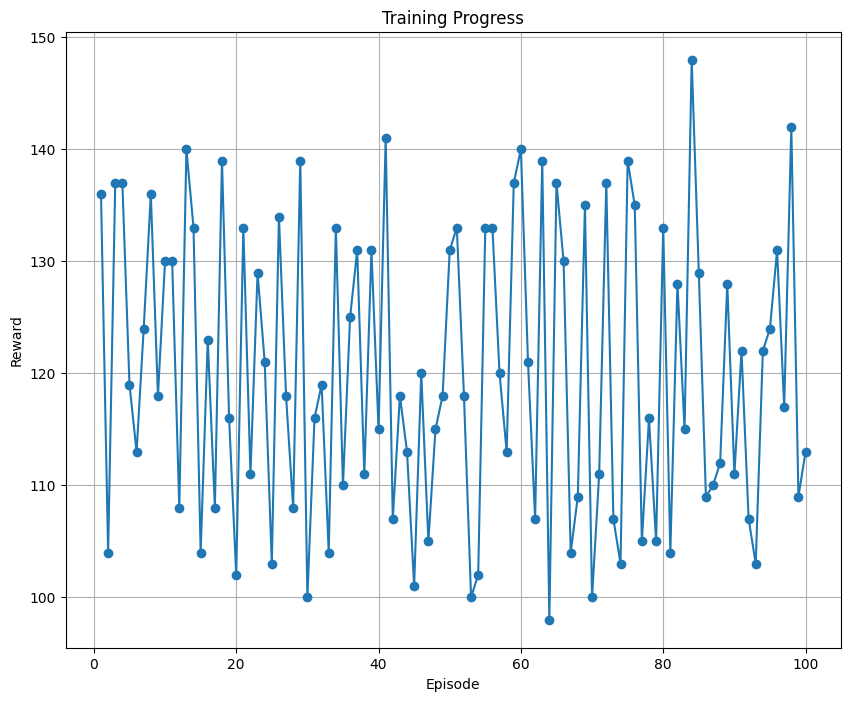

In [ ]:
import imageio
import numpy as np
from IPython.display import Video, display

# Initialize environment and other variables
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
env.reset()
num_episodes = 100
total_steps = 0
reward_array = []
# Iterate over 100 episodes
for episode in range(num_episodes):
    done = False
    env.reset()
    screen = env.render()
    state = env.get_state()
    success = False
    stepCounter = 0
    reward_sum = 0
    while not done:
        action = np.argmax(q_table[state])
        if action == 4 or action == 6:
            continue
        new_state, reward, done, info, _ = env.step(action)
        reward_sum += reward
        state = env.get_state()
        if done:
            success = True
        stepCounter += 1

    # Display episode results
    print(f"Episode {episode}: reward = {reward}, num_of_steps = {stepCounter}")

    # Accumulate total steps
    total_steps += stepCounter
    reward_array.append(reward_sum)

# Compute average number of steps over all episodes
average_steps = total_steps / num_episodes
print(f"Average number of steps over {num_episodes} episodes: {average_steps}")

plt.plot(range(1, len(reward_array) + 1), reward_array, marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.grid(True)
plt.show()


# RandomKeyMEnv_10

###Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

Wall is always in the third column

Key is always in the left part (left to the door)

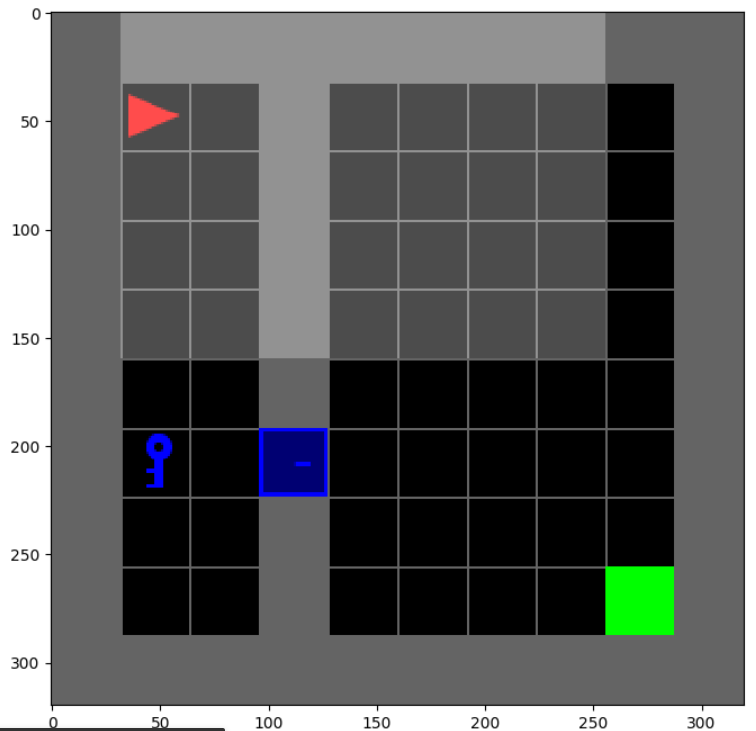

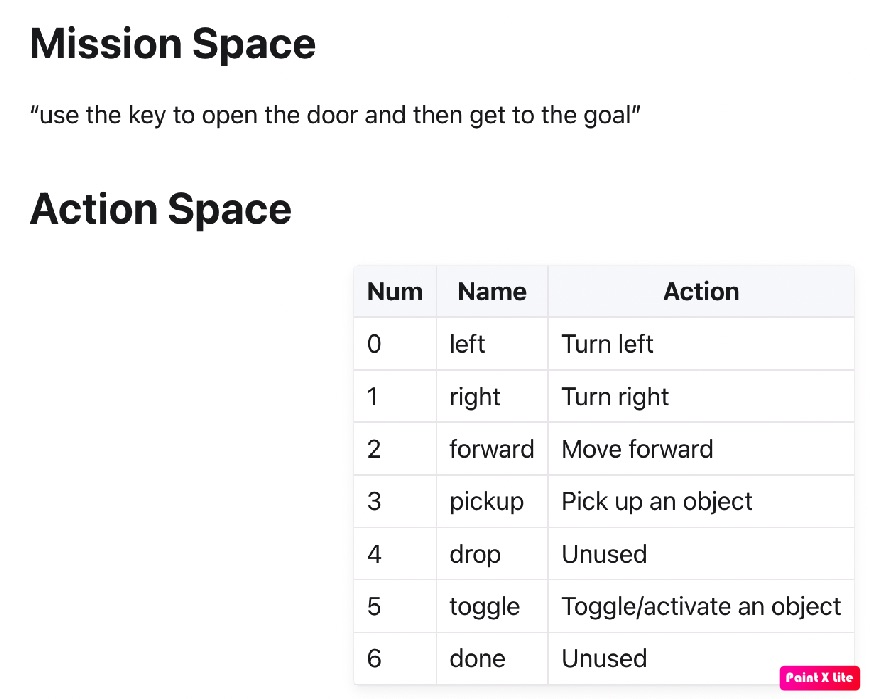

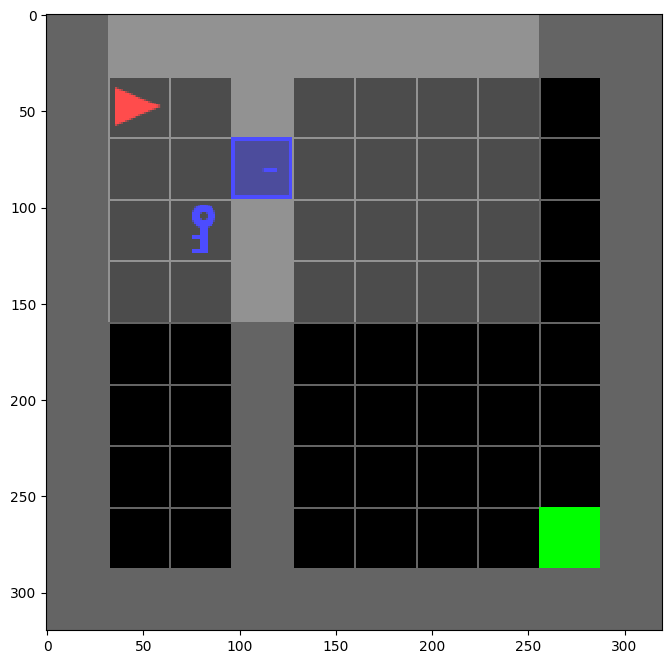

In [ ]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
#env = KeyFlatObsWrapper(KeyMazeEnv_10(render_mode='rgb_array'))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [ ]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


episode: 70, total steps : 21751, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 23789, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 408826, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 24991, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 32217, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 19773, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 17000, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 20094, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 33532, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 31940, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 23529, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 47569, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 63439, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 30708, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70, total steps : 28823, LEARN

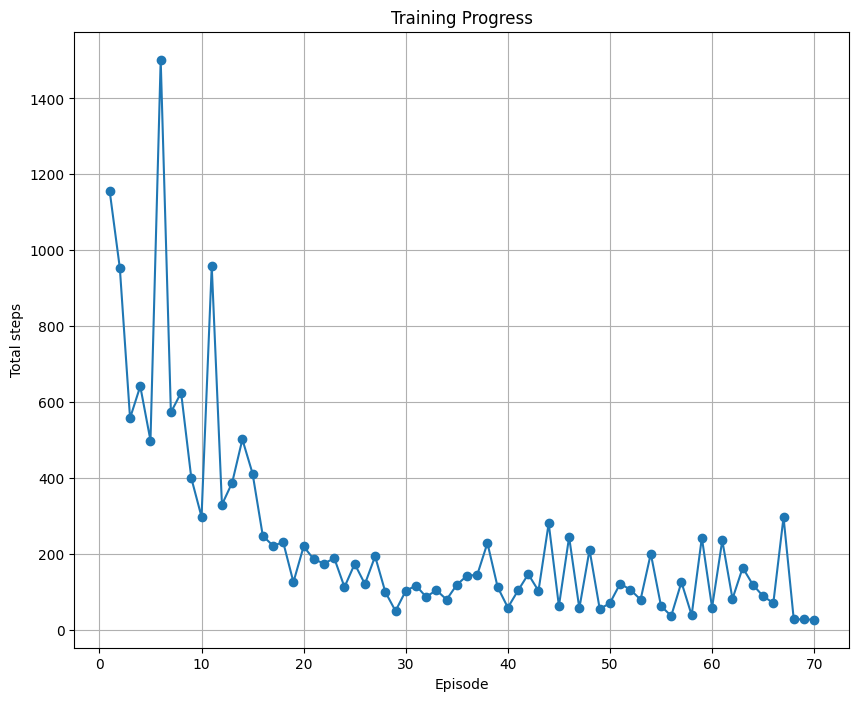

True


In [ ]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game, True)

episode: 70, total steps : 70231, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 80937, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 83816, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 97954, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 89828, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 75230, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 71886, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 72001, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 80283, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 98659, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 102643, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 83890, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 96206, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 176510, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70, total steps : 73164, LEAR

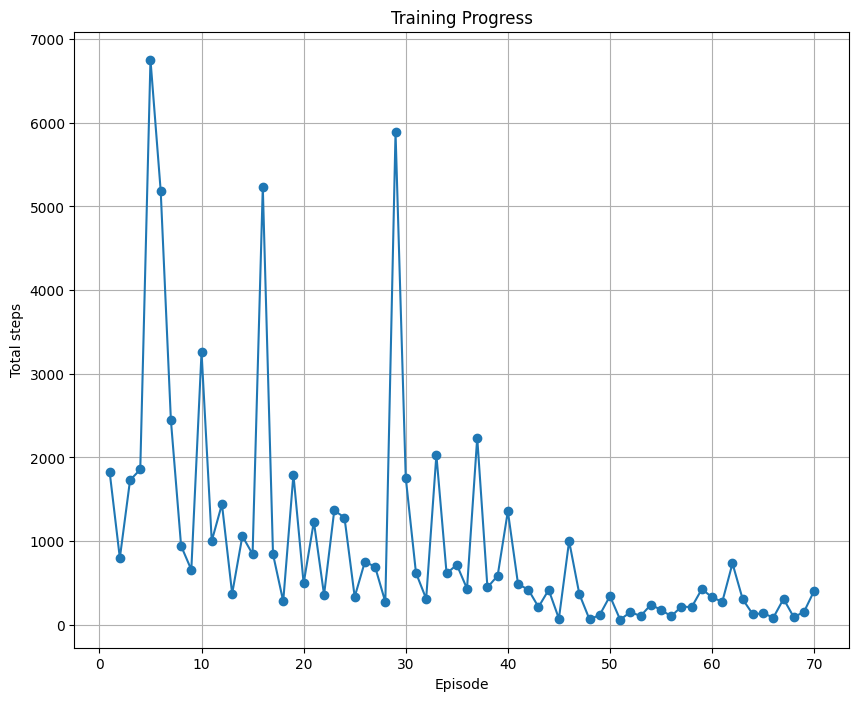

True


In [ ]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game_n_steps, True)

episode: 70, total steps : 1900702, LEARNING_RATE: 0.1,DISCOUNT: 0.8 
episode: 70, total steps : 1964197, LEARNING_RATE: 0.1,DISCOUNT: 0.85 
episode: 70, total steps : 1517255, LEARNING_RATE: 0.1,DISCOUNT: 0.9 
episode: 70, total steps : 1936079, LEARNING_RATE: 0.1,DISCOUNT: 0.95 
episode: 70, total steps : 2268788, LEARNING_RATE: 0.1,DISCOUNT: 0.99 
episode: 70, total steps : 1776565, LEARNING_RATE: 0.2,DISCOUNT: 0.8 
episode: 70, total steps : 1479510, LEARNING_RATE: 0.2,DISCOUNT: 0.85 
episode: 70, total steps : 1701431, LEARNING_RATE: 0.2,DISCOUNT: 0.9 
episode: 70, total steps : 2026452, LEARNING_RATE: 0.2,DISCOUNT: 0.95 
episode: 70, total steps : 2010617, LEARNING_RATE: 0.2,DISCOUNT: 0.99 
episode: 70, total steps : 2230746, LEARNING_RATE: 0.3,DISCOUNT: 0.8 
episode: 70, total steps : 2431184, LEARNING_RATE: 0.3,DISCOUNT: 0.85 
episode: 70, total steps : 1619604, LEARNING_RATE: 0.3,DISCOUNT: 0.9 
episode: 70, total steps : 1696029, LEARNING_RATE: 0.3,DISCOUNT: 0.95 
episode: 70,

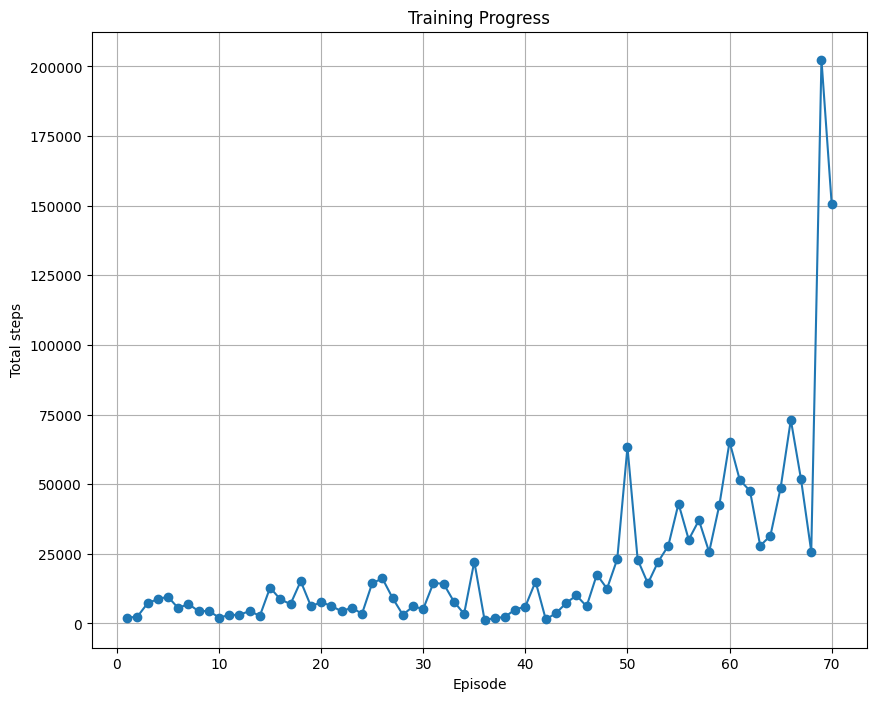

True


In [ ]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
checkingTheBestHyperparameter(run_game_double_q)

# Runing the wining algorithm

episode: 1, total steps : 4695, epsilon:0.8909999099991001, sum: 4695 
episode: 2, total steps : 1638, epsilon:0.8819998199982001, sum: 6333 
episode: 3, total steps : 1101, epsilon:0.8729997299973001, sum: 7434 
episode: 4, total steps : 2426, epsilon:0.8639996399964002, sum: 9860 
episode: 5, total steps : 4548, epsilon:0.8549995499955002, sum: 14408 
episode: 6, total steps : 838, epsilon:0.8459994599946002, sum: 15246 
episode: 7, total steps : 1800, epsilon:0.8369993699937003, sum: 17046 
episode: 8, total steps : 402, epsilon:0.8279992799928003, sum: 17448 
episode: 9, total steps : 2120, epsilon:0.8189991899919004, sum: 19568 
episode: 10, total steps : 1342, epsilon:0.8099990999910004, sum: 20910 
episode: 11, total steps : 458, epsilon:0.8009990099901004, sum: 21368 
episode: 12, total steps : 69, epsilon:0.7919989199892005, sum: 21437 
episode: 13, total steps : 1403, epsilon:0.7829988299883005, sum: 22840 
episode: 14, total steps : 494, epsilon:0.7739987399874005, sum: 2333

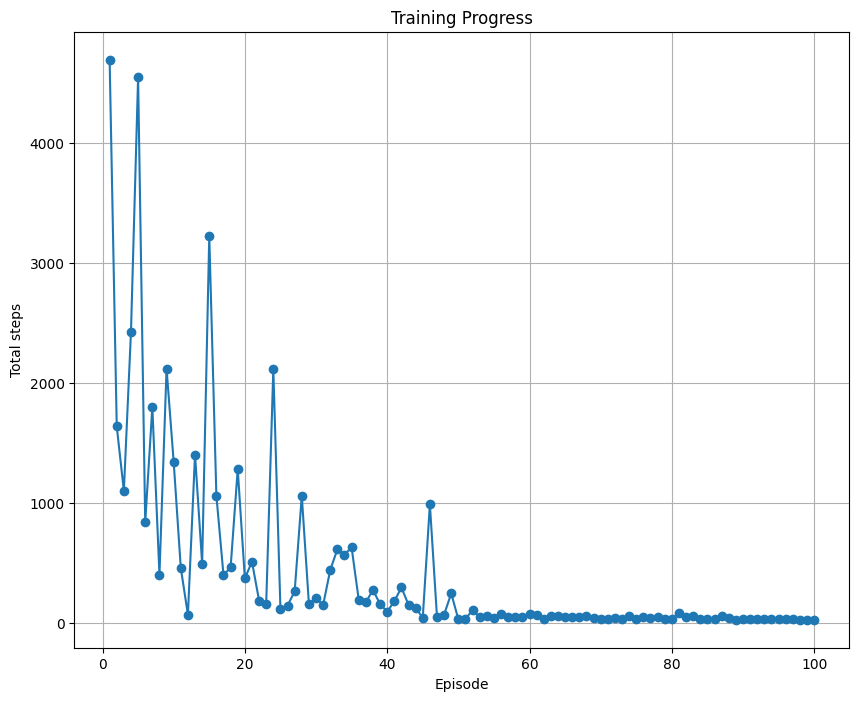

In [ ]:
episode = 0
steps_array = []
LEARNING_RATE = 0.2
DISCOUNT = 0.85
epsilon = 0.9
EPISODES = 1000
START_EPSILON_DECAYING = 0.001
END_EPSILON_DECAYING = EPISODES//10
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
q_table = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))

while episode<EPISODES:
    episode+=1
    # Evaluate current hyperparameters
    env.set_position(3, 5, 1)

    success, steps = run_game(q_table, epsilon)
    # Update best hyperparameters if current configuration is better
    #print(f"Current episode: {episode}, steps: {steps}, epsilon: {epsilon} ")
    steps_array.append(steps)

    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)
    if epsilon < 0.004:
        break
    print(f'episode: {episode}, total steps : {steps}, epsilon:{epsilon}, sum: {sum(steps_array)} ')


# Plot the training progress
plt.plot(range(1, len(steps_array) + 1), steps_array, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.title('Training Progress')
plt.grid(True)
plt.show()


# Training the Agent with Varying Key and Door Positions

Streaming output truncated to the last 5000 lines.
Current episode: 56, steps: 80
Current episode: 56, steps: 231
Current episode: 56, steps: 125
Current episode: 56, steps: 94
Current episode: 56, steps: 957
Current episode: 56, steps: 93
Current episode: 56, steps: 47
Current episode: 56, steps: 56
Current episode: 56, steps: 81
Current episode: 56, steps: 33
Current episode: 56, steps: 41
Current episode: 56, steps: 27
Current episode: 56, steps: 74
Current episode: 56, steps: 220
Current episode: 56, steps: 102
Current episode: 56, steps: 49
Current episode: 56, steps: 29
Current episode: 56, steps: 27
Current episode: 56, steps: 42
Current episode: 56, steps: 56
Current episode: 56, steps: 48
Current episode: 56, steps: 205
Current episode: 56, steps: 1991
Current episode: 56, steps: 161
Current episode: 56, steps: 46
Current episode: 56, steps: 31
Current episode: 56, steps: 60
Current episode: 56, steps: 34
Current episode: 56, steps: 192
Current episode: 56, steps: 49
Current e

/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Current episode: 100, steps: 21
Current episode: 100, steps: 19


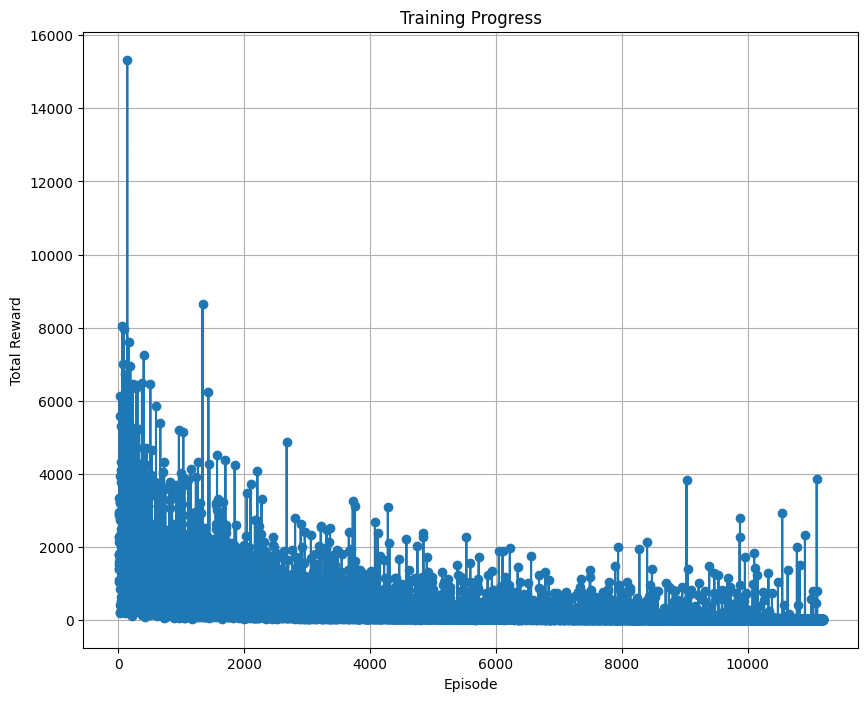

In [ ]:
episode = 0
steps_array = []
epsilon = 0.9
EPISODES = 1000
START_EPSILON_DECAYING = 0.001
END_EPSILON_DECAYING = EPISODES//10
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
LEARNING_RATE = 0.2
DISCOUNT = 0.85
q_table = defaultdict(lambda: [0,0,0,0,float('-inf'),0])
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
middle_video_filename = f'middle key env training.mp4'
end_video_filename = f'end key env training.mp4'

# Loop through the required number of episodes
while episode<EPISODES:
    episode+=1
    done = False
    for door_row in range(1,9):
        for key_row in range(2,9):
            for key_col in range(1,3):
                env.set_position(door_row,key_row, key_col)
                success, steps = run_game(q_table,epsilon)
                print(f"Current episode: {episode}, steps: {steps}")
                steps_array.append(steps)

    with imageio.get_writer(middle_video_filename, fps=10) as video:
        if episode == 50:
          video = imageio.get_writer(middle_video_filename, fps=10)
          success, steps = run_game(q_table,epsilon, video)
    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)
    if epsilon <0.004:
        break
with imageio.get_writer(end_video_filename, fps=10) as video:
  video = imageio.get_writer(end_video_filename, fps=10)
  success, steps = run_game(q_table,epsilon, video)

# Plot the training progress
plt.plot(range(1, len(steps_array) + 1), steps_array, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.grid(True)
plt.show()
embed_mp4(middle_video_filename)

In [ ]:
embed_mp4(end_video_filename)

In [ ]:
import json
# Saving Q table
file_path = "Q table.json"

# Open the file in write mode
with open(file_path, "w") as file:
    # Serialize the dictionary to JSON and write it to the file
    for key, value in q_table.items():
        json.dump(f'key: {key}, value: {value}', file)
        file.write("\n")


In [ ]:
# Loading Q table from JSON
import json
import ast
from ast import literal_eval
q_table = defaultdict(list)
file_path = "Q table.json"
def loadingQTable():
  # Open the JSON file for reading
  with open(file_path, "r") as file:
      # Initialize an empty default dictionary


      # Iterate over each line in the file (assuming each line contains a JSON object)
      for line in file:
          # Load the JSON object from the line
          # Remove surrounding quotes and newline characters
          line = line.strip().strip('"')

          # Split the line into key and value components based on ', value: '
          key_value_split = line.split(', value: ')

          # Extract key and value strings
          key_str = key_value_split[0].replace('key: ', '').strip()
          value_str = key_value_split[1].strip()

          # Parse key string into a Python object using `ast.literal_eval()`
          key = ast.literal_eval(key_str)
          value_str = value_str.replace('-inf', '-10000')

          # Parse value string into a Python object (assuming it's a list of floats)
          value = json.loads(value_str)


          # Append the value to the list associated with the key in the defaultdict
          q_table[key]=value

loadingQTable()
print(q_table)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Average number of steps in test

Episode 0: reward = 100, num_of_steps = 35
Episode 1: reward = 100, num_of_steps = 23
Episode 2: reward = 100, num_of_steps = 29
Episode 3: reward = 100, num_of_steps = 29
Episode 4: reward = 100, num_of_steps = 35
Episode 5: reward = 100, num_of_steps = 20
Episode 6: reward = 100, num_of_steps = 18
Episode 7: reward = 100, num_of_steps = 38
Episode 8: reward = 100, num_of_steps = 27
Episode 9: reward = 100, num_of_steps = 18
Episode 10: reward = 100, num_of_steps = 19
Episode 11: reward = 100, num_of_steps = 19
Episode 12: reward = 100, num_of_steps = 19
Episode 13: reward = 100, num_of_steps = 29
Episode 14: reward = 100, num_of_steps = 29
Episode 15: reward = 100, num_of_steps = 21
Episode 16: reward = 100, num_of_steps = 21
Episode 17: reward = 100, num_of_steps = 18
Episode 18: reward = 100, num_of_steps = 19
Episode 19: reward = 100, num_of_steps = 19
Episode 20: reward = 100, num_of_steps = 21
Episode 21: reward = 100, num_of_steps = 37
Episode 22: reward = 100, num_of_steps = 1

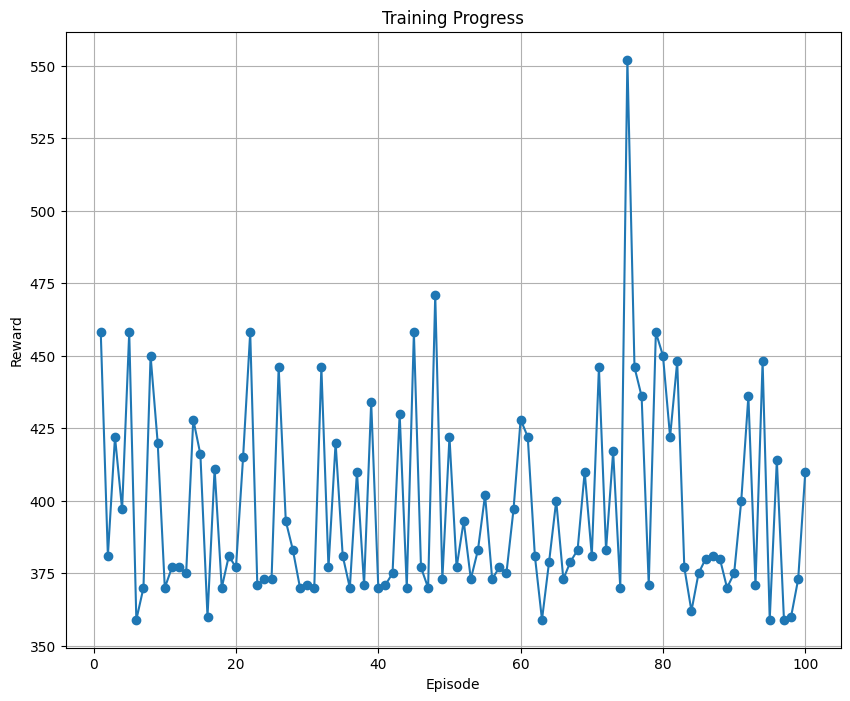

In [ ]:
import imageio
import numpy as np
def avgNumOfSteps():
  # Initialize environment and other variables
  env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
  env.reset()
  num_episodes = 100
  total_steps = 0
  reward_array = []
  # Iterate over 100 episodes
  for episode in range(num_episodes):
      done = False
      env.reset()
      screen = env.render()
      state = env.get_state()
      success = False
      stepCounter = 0
      reward_sum = 0

      while not done:
          action = np.argmax(q_table[state])
          new_state, reward, done, info, _ = env.step(action)
          reward_sum += reward
          state = env.get_state()
          if done:
              success = True
          stepCounter += 1
          if stepCounter == 100:
            print(f'Reach 100 steps in state: {state}')
            break

      # Display episode results
      print(f"Episode {episode}: reward = {reward}, num_of_steps = {stepCounter}")

      # Accumulate total steps
      total_steps += stepCounter
      reward_array.append(reward_sum)

  # Compute average number of steps over all episodes
  average_steps = total_steps / num_episodes
  print(f"Average number of steps over {num_episodes} episodes: {average_steps}")
  plt.plot(range(1, len(reward_array) + 1), reward_array, marker='o')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Training Progress')
  plt.grid(True)
  plt.show()
avgNumOfSteps()